In [1]:

import duckdb
file = "C:/Users/manat/Documents/Projects/mtlBiodiversity/data/db/mtlbio.duckdb"
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN, HDBSCAN


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)

In [3]:
# Function to convert string to datetime
def create_datetime(row):
    from datetime import date
    x = f"{row.year}-{str(row.month).rjust(2, '0')}-{str(row.day).rjust(2, '0')}"
    x = date.fromisoformat(x)
    return x

In [4]:
def max_min_spread(series):
    """Calculates the difference between the max and min of a Series."""
    return series.max() - series.min()

In [12]:
def cluster_spread(group):
    from haversine import haversine

    coords = group[['decimalLatitude', 'decimalLongitude']].values
    centroid = coords.mean(axis=0)
    # mean distance from centroid in meters
    return np.mean([haversine(tuple(p), tuple(centroid)) for p in coords]) * 1000

In [6]:
con = duckdb.connect(file)
df = con.execute("SELECT * from gbif_raw").df()
#df.head()

In [7]:
df['datetime'] = df.apply(create_datetime, axis = 1)


In [8]:
df_user = df.groupby(['recordedBy']).agg(obs = ('gbifID', 'nunique')).sort_values('obs', ascending= False)
top_observers = df_user.index[0:15]
df_user.head(15)


,obs
recordedBy,
Michel Goulet,8632
François Plourde - Renard frak,7542
canouquebec,7446
Serge Benoit,5746
Frederic Desmeules,4116
ornitholarocque,3980
Katherine Collin,3590
sparent66,3449
trejdil,3098


In [16]:
cluster_size = 0.020 #in m
km_per_radian = 6371.0088
epsilon = cluster_size / km_per_radian
print(epsilon)
min_samples = 2

for idx, obs in enumerate(top_observers):

    df_obs = df.loc[df.recordedBy == obs, ['gbifID', 'decimalLatitude', 'decimalLongitude', 'occurrenceID', 'species', 'datetime']]
    coords = np.radians(df_obs[['decimalLatitude', 'decimalLongitude']].values)
    db = DBSCAN(eps=epsilon,
                min_samples=min_samples,
                algorithm='ball_tree',
                metric='haversine').fit(coords)
    
    labels = db.labels_
    df_obs['cluster'] = labels
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    #sns.scatterplot(df_obs, x = 'decimalLongitude', y = 'decimalLatitude', hue = 'cluster')
    #print(df_obs)   
    #plt.show() 
    df_obs = df_obs.loc[df_obs['cluster'] != -1]

    df_clusters = df_obs.groupby('cluster').agg(n_obs = ('gbifID' , 'nunique'),
                                            n_species = ('species','nunique'),
                                            time = ('datetime', max_min_spread),
                                            occurrenceID = ('occurrenceID', 'first'),
                                            ids = ('gbifID', list)
                                            ).assign(spread_m=lambda g: g.index.map(
          lambda c: cluster_spread(df_obs[df_obs['cluster'] == c])
      )).sort_values('n_obs', ascending= False)
    
    if df_clusters.n_obs.iloc[0] >= 100:
        print(obs)
        print(df_clusters.head(5))
        print(df_clusters.occurrenceID.iloc[0])


3.1392202754452326e-06
Estimated number of clusters: 163
Estimated number of noise points: 912
Michel Goulet
         n_obs  n_species      time                                       occurrenceID                                                ids      spread_m
cluster                                                                                                                                                
0         5938        255 4475 days  https://www.inaturalist.org/observations/17285...  [4162317541, 4924166647, 3961399283, 495458594...  1.942901e+02
1          734         74 1129 days  https://www.inaturalist.org/observations/17954...  [4400482362, 4154016405, 3915329151, 390345981...  5.791234e+01
14         252         25  386 days  https://www.inaturalist.org/observations/29959...  [5230876100, 4926308888, 4919513366, 492603534...  1.218031e-09
8          105         25 1155 days  https://www.inaturalist.org/observations/20090...  [4535912065, 4055043853, 4607157557, 460742

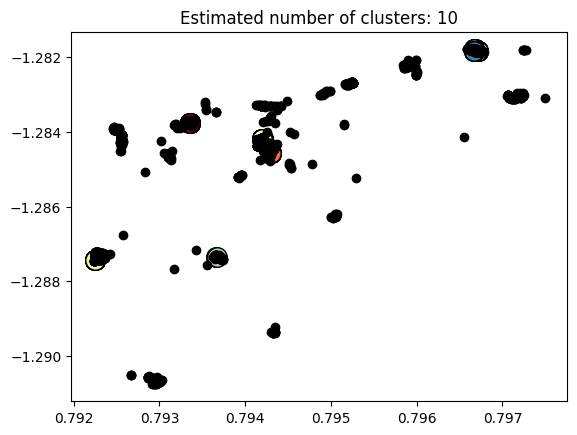

In [ ]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = coords[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = coords[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [ ]:
con.close()